In [1]:
#Importing all packages for the analysis
import pandas as p
import statistics
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import numpy as np
#conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier

C:\Users\eugen\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


STRUCTURE OF ANALYSIS

I. Creation of Analytical data set

II. Exploratory analysis
1) Distribution summary
2) Handling missing observation
3) Handling outliers
4) Feature selection

III. Model building
1) Consumer loan
2) Credit card
3) Mutual fund

IV. Target clients


# Creation of Analytical data set

In [2]:
#Importing excel sheet with all data information
xls = p.ExcelFile('C:/Users/eugen/Desktop/Work/KBC bank/Task_Data_Scientist_Dataset.xlsx')

#Social-demographical data
data_SD=p.read_excel(xls,'Soc_Dem')

#Products owned + actual volumes
data_PAB=p.read_excel(xls,'Products_ActBalance')

#Inflow/outflow on C/A, aggregated card turnover
data_IOF=p.read_excel(xls,'Inflow_Outflow')

#For 60 % of clients actual sales + revenues from these are available
target=p.read_excel(xls,'Sales_Revenues')

The following involves merging the data based on clients with available sales and revenue information. These data were merged on client identification ("Client")

In [9]:
##################################################################
######### Creation of analytical dataset ########################
#################################################################
#Merging "Sales & Revenue" with "Social-demographical" data
data_full_SD=p.merge(target,data_SD, on="Client",how='left')
#Merging the previously merged data with "Products owned + actual volumes" data
data_full_SDPAB=p.merge(data_full_SD,data_PAB,on="Client",how='left')
#Merging the previously merged data with "Inflow/outflow on C/A, aggregated card turnover" data
data_full_final=p.merge(data_full_SDPAB,data_IOF,on="Client",how="left")
data_full_final[0:10]

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Sex,Age,Tenure,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1094,0,1,0,0.000000,5.138571,0.000000,M,25,8,...,1366.313929,1366.313929,53.571429,351.950357,891.327857,31.0,31.0,1.0,21.0,4.0
1,1484,1,0,1,25.609107,0.000000,8.722500,M,39,0,...,768.625000,768.625000,107.142857,302.446429,357.785714,23.0,23.0,1.0,16.0,5.0
2,20,0,1,0,0.000000,3.822500,0.000000,M,27,181,...,221.428571,221.428571,107.142857,10.714286,103.571429,7.0,7.0,3.0,1.0,3.0
3,1193,0,0,0,0.000000,0.000000,0.000000,M,48,16,...,1661.201071,1207.906429,507.142857,331.150000,75.178571,55.0,36.0,6.0,21.0,2.0
4,142,0,0,0,0.000000,0.000000,0.000000,F,27,183,...,728.107143,728.107143,0.000000,0.000000,725.928571,2.0,2.0,0.0,0.0,1.0
5,865,0,0,1,0.000000,0.000000,7.535714,M,23,26,...,441.464286,441.464286,214.285714,14.285714,203.428571,12.0,12.0,3.0,1.0,5.0
6,672,0,1,0,0.000000,1.964286,0.000000,M,4,261,...,291.832143,291.832143,0.000000,0.000000,0.000000,2.0,2.0,0.0,0.0,0.0
7,942,0,1,0,0.000000,36.785714,0.000000,M,40,76,...,173.928571,173.928571,0.000000,0.000000,173.500000,4.0,4.0,0.0,0.0,3.0
8,184,0,1,0,0.000000,5.785714,0.000000,F,30,115,...,131.874286,131.874286,0.000000,129.343214,0.000000,4.0,4.0,0.0,2.0,0.0
9,1513,0,0,1,0.000000,0.000000,13.315714,F,87,149,...,26.000000,26.000000,0.000000,26.000000,0.000000,2.0,2.0,0.0,2.0,0.0


In [39]:
print("Number of clients with sales and revenue information : ",len(data_full_final))

Number of clients with sales and revenue information :  969


In [7]:
data_full_final.to_csv("C:/Users/eugen/Desktop/Work/KBC bank/Analytical_data.csv")

# Exploratory analysis 

# 1) Distribution summary

In [10]:
#Distribution summary of each feature to be used in modelling
data_full_final.loc[:,"Age":"TransactionsDeb_PaymentOrder"].describe()

,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,969.000000,969.000000,969.000000,265.000000,184.000000,251.0,110.0,79.000000,969.000000,265.000000,...,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,42.983488,100.393189,1.075335,1.181132,5.179348,1.0,1.0,1.113924,2493.026329,14427.773550,...,1704.602524,1504.248163,270.893490,157.730155,719.346524,16.365931,13.821241,2.018927,5.360673,4.629863
std,18.578951,65.437097,0.323815,0.457702,9.354897,0.0,0.0,0.319749,6268.027982,32615.370810,...,4636.907178,4371.419774,873.632946,333.325850,3097.920573,16.367897,13.003061,2.709760,8.376615,5.236684
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,42.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,73.135000,725.631429,...,240.738750,220.428571,0.000000,0.000000,0.000000,4.500000,4.000000,0.000000,0.000000,0.000000
50%,41.000000,95.000000,1.000000,1.000000,2.000000,1.0,1.0,1.000000,536.951429,4352.067857,...,691.642857,667.607143,89.285714,26.789286,178.142857,12.000000,11.000000,1.000000,1.000000,3.000000
75%,57.000000,151.000000,1.000000,1.000000,5.000000,1.0,1.0,1.000000,2262.178929,13326.190357,...,1453.959821,1337.509286,357.142857,184.763036,495.377143,23.000000,19.000000,3.000000,7.000000,7.000000
max,90.000000,271.000000,4.000000,3.000000,79.000000,1.0,1.0,2.000000,74934.956071,389883.830714,...,64608.361429,64178.185357,23571.428571,3637.616786,61955.103929,102.000000,83.000000,25.000000,60.000000,34.000000


First observation from the above summary is the age of some clients was 0. Logically, this is not possible! Hence, these clients' ages were imputed with the mean age

In [11]:
#Imputation of the zero ages with the mean age
data_full_final["Age"]=data_full_final["Age"].replace(0,data_full_final["Age"].mean())

In [8]:
#Distribution summary of the target variables
data_full_final.loc[:,"Sale_CC":"Revenue_CL"].describe()

,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,969.000000,969.000000,969.000000,969.000000,969.000000
mean,0.249742,0.299278,1.925015,2.712827,3.604220
std,0.433087,0.458178,9.943601,17.693433,7.743618
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,4.642857
max,1.000000,1.000000,220.488214,407.962500,133.275357


# 2)Handling missing observations

It can be observed that there exist two missing observations in "sex" and >50% of the data was missing in "count_CA", "count_SA", "count_MF", "count_OVD","count_CC", "count_CL","ActBal_CA", "ActBal_SA", "ActBal_MF", "ActBal_OVD","ActBal_CC", "ActBal_CL"

In [170]:
#Number of missing data per variable
print (data_full_final.isnull().sum())

Client                            0
Sale_MF                           0
Sale_CC                           0
Sale_CL                           0
Revenue_MF                        0
Revenue_CC                        0
Revenue_CL                        0
Sex                               2
Age                               0
Tenure                            0
Count_CA                          0
Count_SA                        704
Count_MF                        785
Count_OVD                       718
Count_CC                        859
Count_CL                        890
ActBal_CA                         0
ActBal_SA                       704
ActBal_MF                       785
ActBal_OVD                      718
ActBal_CC                       859
ActBal_CL                       890
VolumeCred                       18
VolumeCred_CA                    18
TransactionsCred                 18
TransactionsCred_CA              18
VolumeDeb                        18
VolumeDeb_CA                

In [12]:
#Imputing missing observations in the quantitative features with mean
var_list=list(data_full_final.drop(['Sex'],axis=1))
for var in var_list:
    data_full_final[var]=data_full_final.drop(['Sex'],axis=1)[var].fillna(data_full_final.drop(['Sex'],axis=1)[var].mean())

In [13]:
#Imputing the missing observations in the "Sex" variable with mode
data_full_final['Sex'] = data_full_final['Sex'].fillna(statistics.mode(data_full_final['Sex']))

In [14]:
#Check if imputation was successful
print (data_full_final.isnull().sum())

Client                          0
Sale_MF                         0
Sale_CC                         0
Sale_CL                         0
Revenue_MF                      0
Revenue_CC                      0
Revenue_CL                      0
Sex                             0
Age                             0
Tenure                          0
Count_CA                        0
Count_SA                        0
Count_MF                        0
Count_OVD                       0
Count_CC                        0
Count_CL                        0
ActBal_CA                       0
ActBal_SA                       0
ActBal_MF                       0
ActBal_OVD                      0
ActBal_CC                       0
ActBal_CL                       0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashl

# 3) Handling outliers


Indentifying which variables have outliers using boxplot. Only "Tenure","Age","Count_CC","Count_OVD" had no outlier

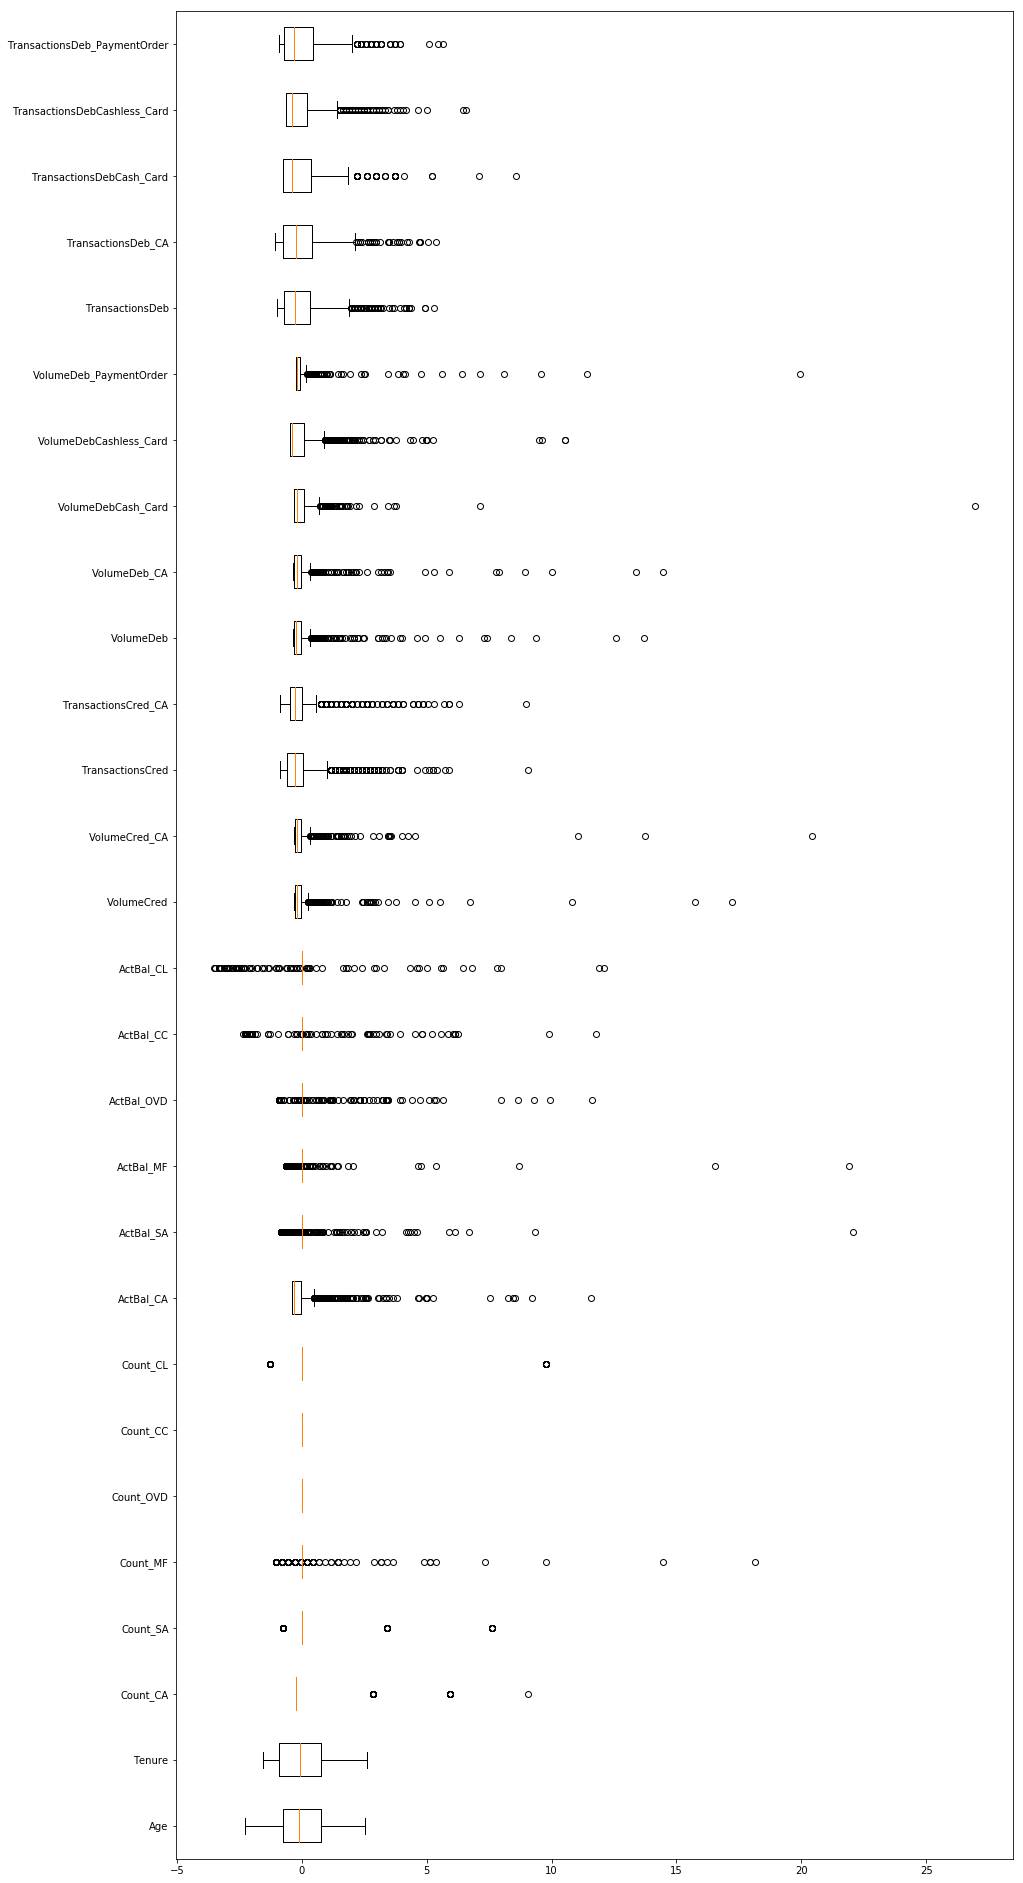

In [33]:
#Box plot creation
data_bp = data_full_final.select_dtypes(exclude=['object']).copy()
data_bp2 = data_bp.drop(['Client','Sale_MF','Sale_CC','Sale_CL','Revenue_MF','Revenue_CC','Revenue_CL'], axis=1)
data_scaled = scale(data_bp2 )

# Create a figure instance
fig = plt.figure(1, figsize=(15, 34))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bxlabs=list(data_bp2)

# Create the boxplot
bp = ax.boxplot(data_scaled,labels=bxlabs,showfliers=True,vert=False)
plt.show()

In [15]:
##########################################################################
################ Creation of truncation function #########################
############################################################################
#This is a method used to handle outliers where they are imputed with the maximum value (if higher than the maximum value)
# and minimum value (if higher than the minimum value)
#The function takes a feature as input
def truncate(Ys):
    
    Q1 = Ys.quantile(0.25)  #First quartile 
    Q3 = Ys.quantile(0.75)  #Third quartile
    IQR = Q3 - Q1           #Interquartile range
    upper_bound =  Q3 + (1.5 * IQR)    #Upper limit
    lower_bound = Q1 - (1.5 * IQR)       #Lower limit
    
    #Imputing the outliers with upper and lower limit
    value_outlier_Y_up = Ys > upper_bound  
    value_outlier_Y_low = Ys < lower_bound
    outlier_listUB=len(Ys[value_outlier_Y_up])
    outlier_listLB=len(Ys[value_outlier_Y_low])
    if outlier_listUB != 0:
        Ys = Ys.replace([Ys[value_outlier_Y_up]], upper_bound)
    if outlier_listLB != 0:
        Ys = Ys.replace([Ys[value_outlier_Y_low]], lower_bound) 
    
    return Ys

In [16]:
#Applying the truncation function on the feature variables
vars_outliers=[ 'Count_CA', 'Count_SA',
                'Count_MF','Count_CL','ActBal_CA','ActBal_SA','ActBal_MF','ActBal_OVD', 'ActBal_CC',
                'ActBal_CL','VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA',
                'VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','TransactionsDeb', 'TransactionsDeb_CA',
                'TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
for i in range(0,len(vars_outliers)):
    data_full_final[vars_outliers[i]]=truncate(data_full_final[vars_outliers[i]])

C:\Users\eugen\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


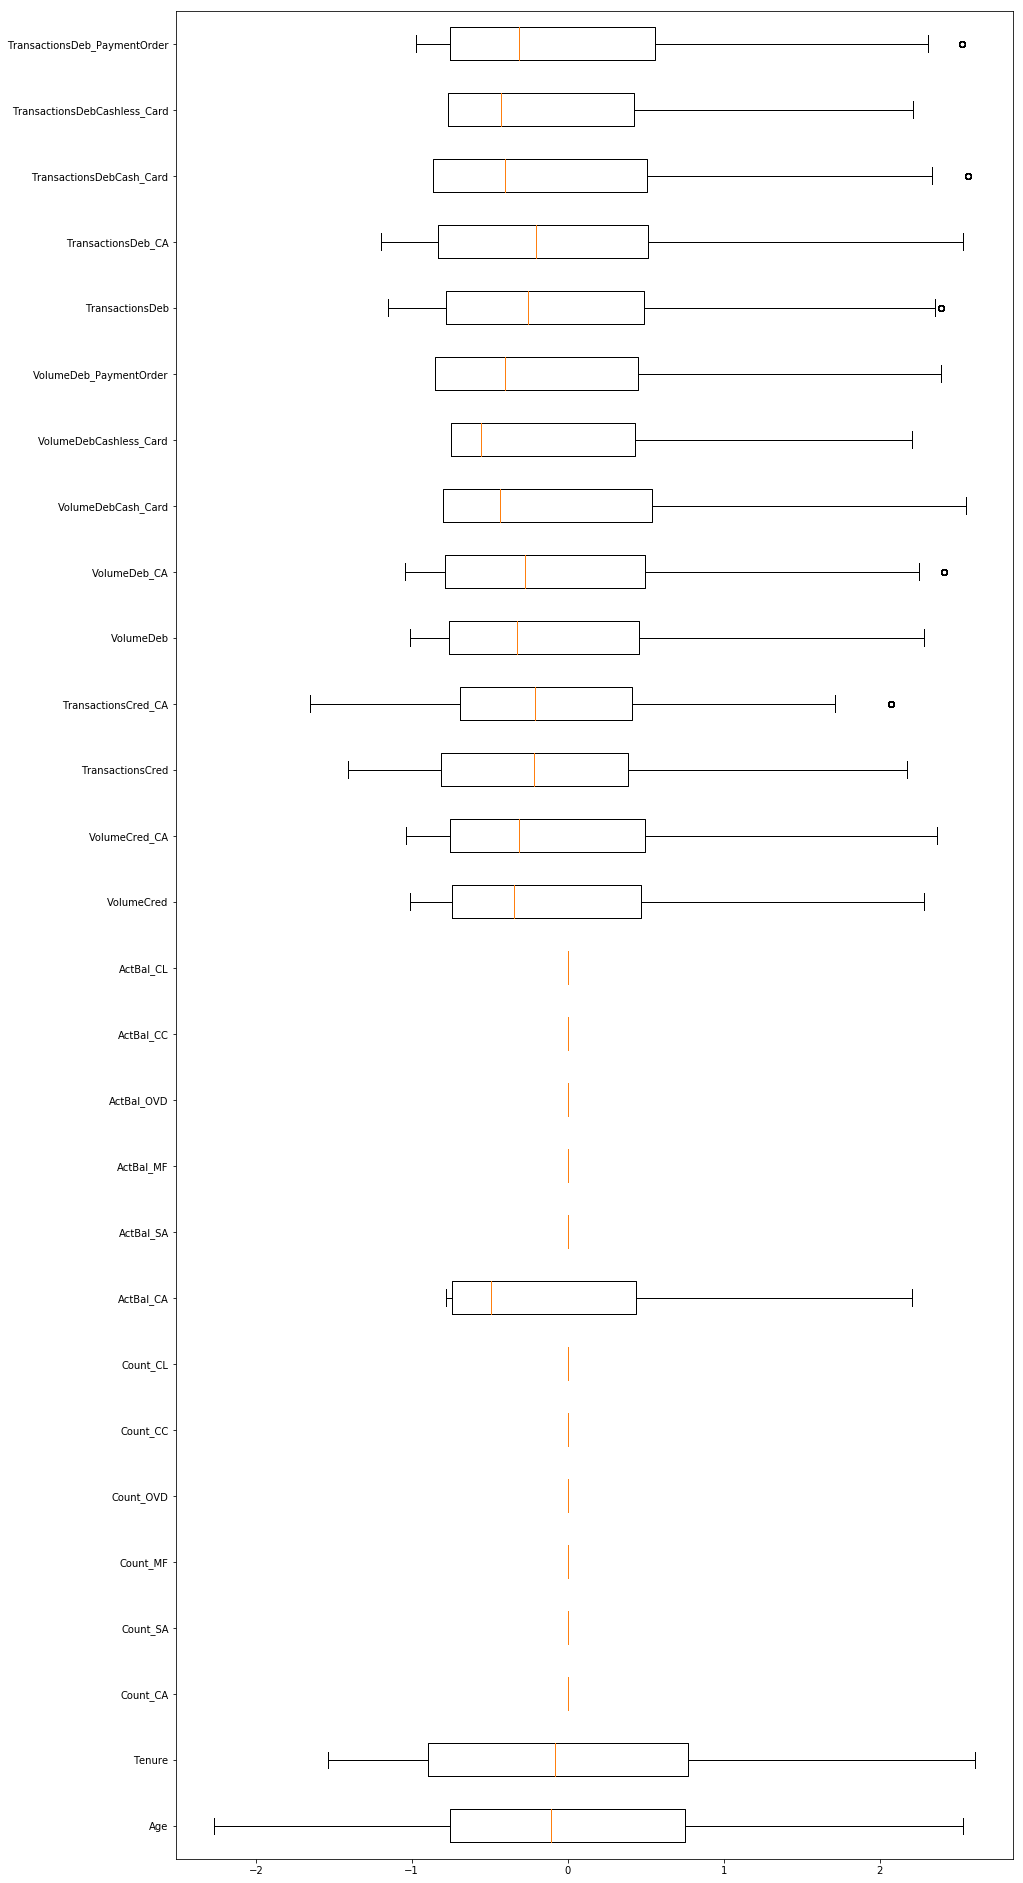

In [36]:
#Creation of boxplot after applying truncation function on the features
data_bp = data_full_final.select_dtypes(exclude=['object']).copy()
data_bp2 = data_bp.drop(['Client','Sale_MF','Sale_CC','Sale_CL','Revenue_MF','Revenue_CC','Revenue_CL'], axis=1)
data_scaled = scale(data_bp2 )

# Create a figure instance
fig = plt.figure(1, figsize=(15, 34))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bxlabs=list(data_bp2)

# Create the boxplot
bp = ax.boxplot(data_scaled,labels=bxlabs,showfliers=True,vert=False)
plt.show()

# 4)Feature selection 


In [17]:
###############################################################################################
########################### Creation of feature selection function ##############################
###############################################################################################
#The function selects only features with information or variance greater than zero
def feature_sel (data):   #Takes in the data as input
    new_feat=[]
    for i in range(0,len(list(data))):
        if statistics.variance(data[list(data)[i]])>0: #Variance check
            new_feat.append(list(data)[i])
    return new_feat

In [18]:
#The feature selection function applied to only the features in the data
feature_sel(data_full_final.drop(['Client','Sale_MF','Sale_CC','Sale_CL','Revenue_MF', 
                                  'Revenue_CC', 'Revenue_CL'],axis=1).select_dtypes(exclude=['object']).copy())

['Age',
 'Tenure',
 'ActBal_CA',
 'VolumeCred',
 'VolumeCred_CA',
 'TransactionsCred',
 'TransactionsCred_CA',
 'VolumeDeb',
 'VolumeDeb_CA',
 'VolumeDebCash_Card',
 'VolumeDebCashless_Card',
 'VolumeDeb_PaymentOrder',
 'TransactionsDeb',
 'TransactionsDeb_CA',
 'TransactionsDebCash_Card',
 'TransactionsDebCashless_Card',
 'TransactionsDeb_PaymentOrder']

# Model building

# 1) Consumer loan

In [176]:
#Number of Clients with (1) and without (0) consumer loan
print(data_full_final['Sale_CL'].value_counts())

0    679
1    290
Name: Sale_CL, dtype: int64


In [124]:
#Selection of features with high information
CL_X= data_full_final.loc[:,['Client',"Revenue_CL",'Age','Tenure','ActBal_CA','VolumeCred','VolumeCred_CA','TransactionsCred',
                             'TransactionsCred_CA','VolumeDeb','VolumeDeb_CA','VolumeDebCash_Card','VolumeDebCashless_Card',
                             'VolumeDeb_PaymentOrder','TransactionsDeb','TransactionsDeb_CA','TransactionsDebCash_Card',
                             'TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']]
#Selection of target
CL_Y=data_full_final["Sale_CL"]

#Splitting into train and test set
trainCL_X, testCL_X, trainCL_y, testCL_y = train_test_split(CL_X, CL_Y, test_size=0.2, random_state=12)

#Reseting indexes after randomly splitting the data into train and test set
trainCL_X2=p.DataFrame(trainCL_X.reset_index(drop=True).drop(['Client','Revenue_CL'],axis=1))
testCL_X2=p.DataFrame(testCL_X.reset_index(drop=True).drop(['Client','Revenue_CL'],axis=1))
trainCL_y2=trainCL_y.reset_index(drop=True)
testCL_y2=testCL_y.reset_index(drop=True)

#To obtain the client IDs later on from the test set
test_clientCL=testCL_X.reset_index(drop=True)['Client']
test_revCL=testCL_X.reset_index(drop=True)['Revenue_CL']

#Handling class imbalance using Synthetical Minority Over-sampling(SMOTE)
sm = SMOTE( k_neighbors=3, random_state=12)
trainCL_X2_res, trainCL_y2_res = sm.fit_sample(trainCL_X2, trainCL_y2)


#Validation set approach to build Logistic model
logreg = LogisticRegression()
logreg.fit(trainCL_X2_res,trainCL_y2_res)

#Validation set approach to build Random forest model
CL_RF = RandomForestClassifier(random_state=0,n_estimators = 100)
CL_RF.fit(trainCL_X2_res,trainCL_y2_res)


#Validation set approach to build 7-nearest neighbours
CL_NBclass=KNeighborsClassifier(n_neighbors=7)
CL_NBclass.fit(trainCL_X2_res,trainCL_y2_res)

#Validation set approach to build ensemble classifier
stack_CL=VotingClassifier(estimators=[('logreg',logreg),('RandForest',CL_RF),('KNN_class',CL_NBclass)],voting='soft')
stack_CL.fit(trainCL_X2_res,trainCL_y2_res)


#AUC for both logistic, random forest models, 3-nearest neighbour
print("AUC for logistic model : ",roc_auc_score(testCL_y2,logreg.predict(testCL_X2)))
print("AUC for random forest : ",roc_auc_score(testCL_y2,CL_RF.predict(testCL_X2)))
print("AUC for 3-nearest neighbour : " , roc_auc_score(testCL_y2,CL_NBclass.predict(testCL_X2)))
print("AUC for ensemble model: ",roc_auc_score(testCL_y2,stack_CL.predict(testCL_X2)))


AUC for logistic model :  0.5406678592725105
AUC for random forest :  0.5841383422778771
AUC for 3-nearest neighbour :  0.47889087656529516
AUC for ensemble model:  0.5333333333333333


C:\Users\eugen\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [123]:
#Preceision and recall for random forest
print(classification_report(testCL_y2,CL_RF.predict(testCL_X2)))

             precision    recall  f1-score   support

          0       0.71      0.88      0.78       129
          1       0.54      0.29      0.38        65

avg / total       0.65      0.68      0.65       194



In [144]:
##########################################################################################################
############### Obtaining the expected revenues of clients with consumer loan #######################
##########################################################################################################
#Using Clients with above 60% chance of owning a consumer loan
high_probs_CL=CL_RF.predict_proba(testCL_X2)[:,1]>0.6
probs_CL=CL_RF.predict_proba(testCL_X2)[:,1][high_probs_CL]
#pos_data=data_full_final.loc[:,:][high_probs_CL]
CLRev_Y=test_revCL[high_probs_CL]
CLRev_X=testCL_X2[high_probs_CL]

#Preparing results for expected revenues along with their client ID and probability to own a consumer loan
data={"Exp_RevCL":CLRev_Y,
      "Prob_RevCL":probs_CL,
     "Client":test_clientCL[high_probs_CL]}
Exp_RevCL_df=p.DataFrame(data, columns=['Client','Prob_RevCL','Exp_RevCL'])

#Selection the top 100 clients with highest propensity to own a consumer loan
CL_Clients=Exp_RevCL_df.sort_values(by=["Prob_RevCL"],ascending=False)[0:100]
CL_Clients[0:5]

,Client,Prob_RevCL,Exp_RevCL
161,519,0.77,5.500000
27,1333,0.71,0.000000
46,859,0.70,4.166786
28,1198,0.68,0.000000
102,384,0.68,12.506071


In [145]:
print("Number of highly probable clients to have consumer loan : ",len(CL_Clients))

Number of highly probable clients to have consumer loan :  14


# 2)Credit card

In [60]:
#Number of clients with (1) and without (0) credit card ownership
print(data_full_final['Sale_CC'].value_counts())

0    727
1    242
Name: Sale_CC, dtype: int64


In [113]:
#Selection of features with high information
CC_X= data_full_final.loc[:,['Client','Revenue_CC','Age','Tenure','ActBal_CA','VolumeCred','VolumeCred_CA','TransactionsCred',
                             'TransactionsCred_CA','VolumeDeb','VolumeDeb_CA','VolumeDebCash_Card','VolumeDebCashless_Card',
                             'VolumeDeb_PaymentOrder','TransactionsDeb','TransactionsDeb_CA','TransactionsDebCash_Card',
                             'TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']]
#Selection of target 
CC_Y=data_full_final["Sale_CC"]

#Splitting into train and test set
trainCC_X, testCC_X, trainCC_y, testCC_y = train_test_split(CC_X, CC_Y, test_size=0.2, random_state=12)
skf = StratifiedKFold(n_splits=10, random_state=0)

#Reseting indexes after randomly splitting the data into train and test set
trainCC_X2=p.DataFrame(trainCC_X.reset_index(drop=True).drop(['Client','Revenue_CC'],axis=1))
testCC_X2=p.DataFrame(testCC_X.reset_index(drop=True).drop(['Client','Revenue_CC'],axis=1))
trainCC_y2=trainCC_y.reset_index(drop=True)
testCC_y2=testCC_y.reset_index(drop=True)

#To obtain the client IDs later on from the test set
test_clientCC=testCC_X.reset_index(drop=True)['Client']
test_revCC=testCC_X.reset_index(drop=True)['Revenue_CC']

#Handling class imbalance using Synthetical Minority Over-sampling(SMOTE)
sm = SMOTE( k_neighbors=3, random_state=12)
trainCC_X2_res, trainCC_y2_res = sm.fit_sample(trainCC_X2, trainCC_y2)

#Validation set approach to build Logistic model
logreg_CC = LogisticRegression()
logreg_CC.fit(trainCC_X2_res,trainCC_y2_res)

#Validation set approach to build Random forest model
CC_RF = RandomForestClassifier(random_state=0,n_estimators = 100)
CC_RF.fit(trainCC_X2_res,trainCC_y2_res)

#Validation set approach to build 3-nearest neighbour classifier
CC_NBclass=KNeighborsClassifier(n_neighbors=7)
CC_NBclass.fit(trainCC_X2_res,trainCC_y2_res)

#Validation set approach to build stacking classifier
stack_CC=VotingClassifier(estimators=[('logreg',logreg_CC),('RandForest',CC_RF),('KNN_class',CC_NBclass)],voting='soft')
stack_CC.fit(trainCC_X2_res,trainCC_y2_res)

#AUC for both logistic, random forest models, 7 nearest neigbhours classifier and ensemble classifier
print("AUC for logistic model : ",roc_auc_score(testCC_y2,logreg_CC.predict(testCC_X2)))
print("AUC for random forest : ",roc_auc_score(testCC_y2,CC_RF.predict(testCC_X2)))
print("AUC for 7-nearest neighbours : ",roc_auc_score(testCC_y2,CC_NBclass.predict(testCC_X2)))
print("AUC for ensemble model : ",roc_auc_score(testCC_y2,stack_CC.predict(testCC_X2)))   

AUC for logistic model :  0.5600763807285546
AUC for random forest :  0.5302585193889542
AUC for 7-nearest neighbours :  0.5779964747356052
AUC for ensemble model :  0.6107520564042302


C:\Users\eugen\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [114]:
#Preceision and recall for ensemble classifier
print(classification_report(testCL_y2,stack_CC.predict(testCC_X2)))

             precision    recall  f1-score   support

          0       0.68      0.71      0.69       129
          1       0.37      0.34      0.35        65

avg / total       0.57      0.58      0.58       194



C:\Users\eugen\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [142]:
##########################################################################################################
############### Obtaining the expected revenues of clients with credit card #######################
##########################################################################################################

#Using Clients with above 60% chance of owning a credit card
high_probs_CC=stack_CC.predict_proba(testCC_X2)[:,1]>=0.6
probs_CC=stack_CC.predict_proba(testCC_X2)[:,1][high_probs_CC]
#CCRev_X=CC_X[high_probs_CC]

#Preparing results for expected revenues along with their client ID and probability to own a credit card
data={"Exp_RevCC":test_revCC[high_probs_CC],
      "Prob_RevCC":probs_CC,
     "Client":test_clientCC[high_probs_CC]}
Exp_RevCC_df=p.DataFrame(data, columns=['Client','Prob_RevCC','Exp_RevCC'])

#Selection the top 100 clients with highest propensity to own a credit card
CC_Clients=Exp_RevCC_df.sort_values(by=["Prob_RevCC"],ascending=False)[0:100]
CC_Clients[0:5]

,Client,Prob_RevCC,Exp_RevCC
186,946,0.769912,0.644286
108,979,0.709245,0.000000
130,1246,0.697116,4.464286
150,1428,0.681046,0.000000
23,1264,0.642284,0.000000


In [143]:
print("Number of clients with highly probable credit card : ",len(CC_Clients))

Number of clients with highly probable credit card :  22


# 3)Mutual fund

In [87]:
#Number of clients with (1) and without (0) mutual fund ownership
print(data_full_final['Sale_MF'].value_counts())

0    776
1    193
Name: Sale_MF, dtype: int64


In [134]:
#Selection of features with high information
MF_X= data_full_final.loc[:,['Client','Revenue_MF','Age','Tenure','ActBal_CA','VolumeCred','VolumeCred_CA','TransactionsCred',
                             'TransactionsCred_CA','VolumeDeb','VolumeDeb_CA','VolumeDebCash_Card','VolumeDebCashless_Card',
                             'VolumeDeb_PaymentOrder','TransactionsDeb','TransactionsDeb_CA','TransactionsDebCash_Card',
                             'TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']]
#Selection of target
MF_Y=data_full_final["Sale_MF"]

#Splitting into train and test set
trainMF_X, testMF_X, trainMF_y, testMF_y = train_test_split(MF_X, MF_Y, test_size=0.2, random_state=12)
#skf = StratifiedKFold(n_splits=10, random_state=0)

#Reseting indexes after randomly splitting the data into train and test set
trainMF_X2=p.DataFrame(trainMF_X.reset_index(drop=True).drop(['Client','Revenue_MF'],axis=1))
testMF_X2=p.DataFrame(testMF_X.reset_index(drop=True).drop(['Client','Revenue_MF'],axis=1))
trainMF_y2=trainMF_y.reset_index(drop=True)
testMF_y2=testMF_y.reset_index(drop=True)

#To obtain the client IDs later on from the test set
test_clientMF=testMF_X.reset_index(drop=True)['Client']
test_revMF=testMF_X.reset_index(drop=True)['Revenue_MF']


#Handling class imbalance using Synthetical Minority Over-sampling(SMOTE)
sm = SMOTE( k_neighbors=3, random_state=12)
trainMF_X2_res, trainMF_y2_res = sm.fit_sample(trainMF_X2, trainMF_y2)


#Validation set approach to build Logistic model
logreg_MF = LogisticRegression()
logreg_MF.fit(trainMF_X2_res,trainMF_y2_res)

#Validation set approach to build Random forest model
MF_RF = RandomForestClassifier(random_state=0,n_estimators = 100)
MF_RF.fit(trainMF_X2_res,trainMF_y2_res)

#Validation set approach to build 7 nearest neighbour classifier
MF_NBclass=KNeighborsClassifier(n_neighbors=7)
MF_NBclass.fit(trainMF_X2_res,trainMF_y2_res)

#Validation set approach to build stacking classifier
stack_MF=VotingClassifier(estimators=[('logreg',logreg_MF),('RandForest',MF_RF),('KNN_class',MF_NBclass)],voting='soft')
stack_MF.fit(trainCL_X2_res,trainCL_y2_res)

#AUC for both logistic and random forest models
print("AUC for logistic model : ",roc_auc_score(testMF_y2,logreg_MF.predict(testMF_X2)))
print("AUC for random forest : ",roc_auc_score(testMF_y2,MF_RF.predict(testMF_X2)))
print("AUC for 7-nearest neighbours : ", roc_auc_score(testMF_y2,MF_NBclass.predict(testMF_X2)))
print("AUC for ensemble model : ",roc_auc_score(testMF_y2,stack_MF.predict(testMF_X2)))

AUC for logistic model :  0.5862454811499398
AUC for random forest :  0.5158374935444999
AUC for 7-nearest neighbours :  0.5362368738164917
AUC for ensemble model :  0.48063349974178005


C:\Users\eugen\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [135]:
#Preceision and recall for logistic regression
print(classification_report(testMF_y2,logreg_MF.predict(testMF_X2)))

             precision    recall  f1-score   support

          0       0.87      0.50      0.63       157
          1       0.24      0.68      0.35        37

avg / total       0.75      0.53      0.58       194



In [140]:
##########################################################################################################
############### Obtaining the expected revenues of clients with mutual fund #######################
##########################################################################################################

#Using Clients with above 60% chance of owning a mutual fund
high_probs_MF=logreg_MF.predict_proba(testMF_X2)[:,1]>=0.6
probs_MF=logreg_MF.predict_proba(testMF_X2)[:,1][high_probs_MF]
MFRev_Y=test_revMF[high_probs_MF]
#MFRev_X=MF_X[high_probs_MF]

#Preparing results for expected revenues along with their client ID and probability to own a mutual fund
data={"Exp_RevMF":MFRev_Y,
      "Prob_RevMF":probs_MF,
     "Client":test_clientMF[high_probs_MF]}
Exp_RevMF_df=p.DataFrame(data, columns=['Client','Prob_RevMF','Exp_RevMF'])


#Selection the top 100 clients with highest propensity to own a mutual fund
MF_Clients=Exp_RevMF_df.sort_values(by=["Prob_RevMF"],ascending=False)[0:100]
MF_Clients[0:5]

,Client,Prob_RevMF,Exp_RevMF
180,416,0.878957,10.363036
67,1502,0.809147,34.016607
125,1412,0.797193,6.795536
6,984,0.786810,0.000000
103,1254,0.781794,0.000000


In [141]:
print("Number of highly probable clients to have a mutual fund : ",len(MF_Clients))

Number of highly probable clients to have a mutual fund :  42


# Target clients

In [148]:
#Summary of each client with and without a product
CLCC_Clients=p.merge(CL_Clients,CC_Clients,on='Client',how='outer')
Final_Clients=p.merge(CLCC_Clients,MF_Clients,on='Client',how='outer')
Final_Clients.loc[:,["Client","Exp_RevCL","Exp_RevCC","Exp_RevMF"]]

,Client,Exp_RevCL,Exp_RevCC,Exp_RevMF
0,519,5.500000,NaN,NaN
1,1333,0.000000,NaN,NaN
2,859,4.166786,NaN,NaN
3,1198,0.000000,NaN,NaN
4,384,12.506071,NaN,NaN
5,365,0.000000,NaN,NaN
6,1254,2.107143,NaN,0.000000
7,984,0.000000,NaN,0.000000
8,1565,15.714286,NaN,0.000000
9,775,19.035714,0.000000,NaN


In [149]:
#Summary of expected revenues per product
len(Final_Clients)
Final_Clients.loc[:,["Exp_RevCL","Exp_RevCC","Exp_RevMF"]].sum(axis = 0, skipna = True) 

Exp_RevCL     89.490357
Exp_RevCC     50.212500
Exp_RevMF    152.593036
dtype: float64

In [151]:
#Saving the clients with high propensity to bye a product
Final_Clients.loc[:,["Client","Exp_RevCL","Exp_RevCC","Exp_RevMF"]].to_csv("C:/Users/eugen/Desktop/Work/KBC bank/contact_clients.csv")